In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pandas.core.dtypes.common import is_numeric_dtype

DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

In [47]:
from umap import UMAP
def boundary_on_UMAP_proj(X, true_class, clf, class_inverse_function, n_points=50):
    """Utility for plotting a decision boundary on a UMAP projection.
    class_inverse_function is the (prediction -> label) transformer, e.g. if model is onehot encoded

    predictions = [[0.1, 0.9], [0.2, 0.8], ..]
    class = predictions[:, 1]
    """

    fig, ax = plt.subplots()
    ax.axis("off")

    reducer = UMAP(n_components=2, n_neighbors=50)
    embedding = reducer.fit_transform(X)

    xx = np.linspace(np.min(embedding[:, 0]), np.max(embedding[:,0]), n_points)
    yy = np.linspace(np.min(embedding[:, 1]), np.max(embedding[:,1]), n_points)
    points = np.stack( np.meshgrid(xx, yy) ).T.reshape(-1,2)

    points_expanded = reducer.inverse_transform(points)
    expected_class = class_inverse_function(clf.predict(points_expanded))

    ax.contourf(xx, yy, np.rot90(expected_class.reshape(-1, n_points).T, k=0), alpha=0.3, cmap="viridis", levels=2)
    ax.scatter(*embedding.T, c=true_class, cmap="viridis", s= 5)

## Unbalanced emozioni

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA

X = MinMaxScaler().fit_transform( PCA(n_components=20).fit_transform(df[numerical_attr_list]))

ohenc = OneHotEncoder()
y = ohenc.fit_transform( (df["actor"]=="actor_5").values.reshape(-1,1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

weights = np.ones(y.shape[0]) # ((y_train[:, 1] == 1).astype(int) + 1)/32

In [49]:
from keras.layers import Input, Dense , Dropout
from keras.metrics import BinaryCrossentropy, CategoricalCrossentropy, BinaryAccuracy
from keras.losses import BinaryCrossentropy as bce_loss
from keras.models import Model

input = Input(shape=(X.shape[1]), name="input")
dense = Dense(256, activation="relu")(input)
dense = Dense(256, activation="relu")(dense)
dense = Dense(256, activation="relu")(dense)
dense = Dense(256, activation="relu")(dense)

output = Dense(y.shape[1], activation="softmax", name="output")(dense)

model = Model(inputs=input, outputs=output, name="DenseNetwork")
model.compile(optimizer="adam",
            loss=bce_loss(from_logits=False),
            metrics= [BinaryCrossentropy(from_logits=False), BinaryAccuracy()],
            weighted_metrics=[BinaryCrossentropy(from_logits=False), BinaryAccuracy()])
model.summary()

Model: "DenseNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 20)]              0         
                                                                 
 dense_16 (Dense)            (None, 256)               5376      
                                                                 
 dense_17 (Dense)            (None, 256)               65792     
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 output (Dense)              (None, 2)                 514       
                                                                 
Total params: 203,266
Trainable params: 203,266
Non-tr

In [50]:
history = model.fit(X_train, y_train, sample_weight=weights, 
                    epochs=10, batch_size=10, verbose=1, 
                    validation_split = 0.05)

Epoch 1/10
185/185 [==============================] - 6s 15ms/step - loss: 0.2124 - binary_crossentropy: 0.2124 - binary_accuracy: 0.9523 - weighted_binary_crossentropy: 0.2124 - weighted_binary_accuracy: 0.9523 - val_loss: 0.1678 - val_binary_crossentropy: 0.1678 - val_binary_accuracy: 0.9694 - val_weighted_binary_crossentropy: 0.1678 - val_weighted_binary_accuracy: 0.9694
Epoch 2/10
185/185 [==============================] - 2s 10ms/step - loss: 0.1701 - binary_crossentropy: 0.1701 - binary_accuracy: 0.9523 - weighted_binary_crossentropy: 0.1701 - weighted_binary_accuracy: 0.9523 - val_loss: 0.2308 - val_binary_crossentropy: 0.2308 - val_binary_accuracy: 0.9694 - val_weighted_binary_crossentropy: 0.2308 - val_weighted_binary_accuracy: 0.9694
Epoch 3/10
185/185 [==============================] - 2s 9ms/step - loss: 0.1569 - binary_crossentropy: 0.1569 - binary_accuracy: 0.9523 - weighted_binary_crossentropy: 0.1569 - weighted_binary_accuracy: 0.9523 - val_loss: 0.1144 - val_binary_cro

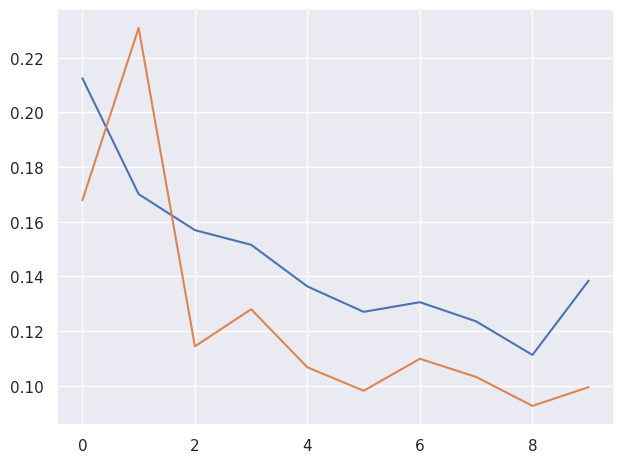

In [51]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

4/4 [==============================] - 0s 3ms/step
[[9.9925423e-01 7.4586988e-04]
 [9.9990982e-01 9.0116795e-05]
 [9.9999994e-01 2.6039980e-12]
 [9.9999994e-01 5.0832473e-14]
 [9.9999994e-01 2.6039980e-12]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


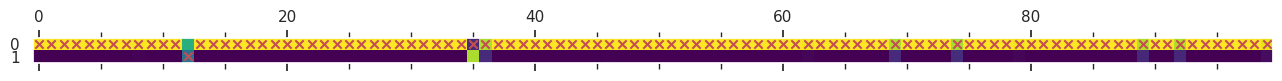

In [52]:
who = np.random.randint(len(y_test),size=100)
predictions=model.predict(X_test[who,:])
plt.matshow(predictions.T, cmap = "viridis")
plt.scatter( np.arange(len(who)), np.argmax(y_test[who], axis=-1), marker="x", color="r")
plt.grid("")

print(predictions[:5])
print(y_test[who][:5])

In [53]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(ohenc.inverse_transform(y_test), ohenc.inverse_transform(y_pred)))

16/16 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       False       0.98      0.99      0.98       473
        True       0.33      0.23      0.27        13

    accuracy                           0.97       486
   macro avg       0.66      0.61      0.63       486
weighted avg       0.96      0.97      0.96       486



79/79 [==============================] - 0s 3ms/step


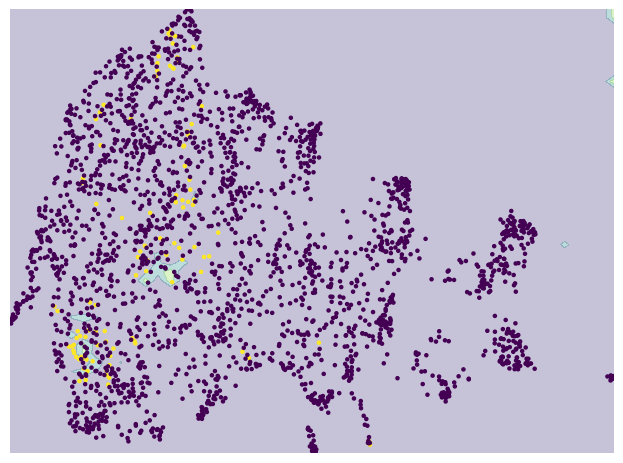

In [54]:
boundary_on_UMAP_proj(X, 
                      y[:,1], 
                      model, 
                      lambda x: x[:, 1])

## GradientBoosting Machine

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

X = MinMaxScaler().fit_transform( PCA(n_components=20).fit_transform(df[numerical_attr_list]))
print(df[df.columns.difference(["emotion"])])
X = np.stack((X, ))

print(X)
y = (df["emotion"] == "angry").values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

alberto = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=3, random_state=0)
alberto.fit(X_train, y_train)
pred = alberto.predict(X_test)
print(classification_report(y_true=y_test, y_pred=pred))

      ABOD_score  ISFO_score  LOF_score     actor  aggregatedOD_score   
0       0.980251    0.787895   0.681241   actor_1            0.825156  \
1       0.895964    0.806915   0.696252   actor_1            0.797518   
2       0.969390    0.867751   0.744019   actor_1            0.858145   
3       0.976629    0.914533   0.882653   actor_1            0.927670   
4       0.984354    0.755409   0.719811   actor_1            0.839473   
...          ...         ...        ...       ...                 ...   
2424    0.732583    0.803156   0.933586  actor_24            0.829181   
2425    0.857641    0.737803   0.886745  actor_24            0.854664   
2426    0.929044    0.754997   0.750720  actor_24            0.828810   
2427    0.945423    0.726142   0.829472  actor_24            0.866408   
2428    0.935861    0.782373   0.789047  actor_24            0.852008   

     emotional_intensity  frame_count  is_ABOD_outlier  is_ISFO_outlier   
0                 normal       160160           

ValueError: Found input variables with inconsistent numbers of samples: [1, 2429]

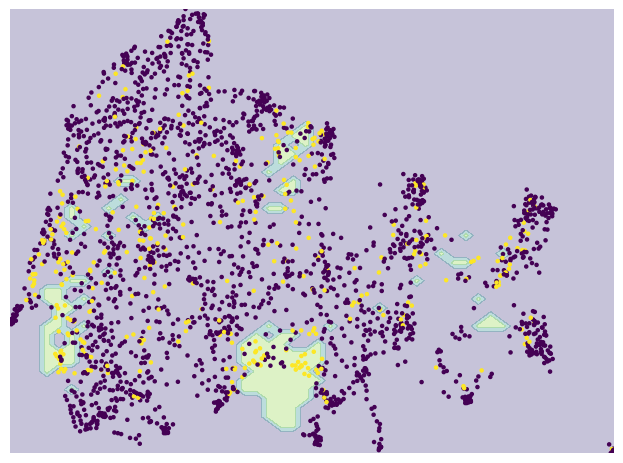

In [65]:
boundary_on_UMAP_proj(X, y.astype(int), alberto, lambda x: x.astype(int) )